In [1]:
import numpy as np
import cv2
import app.calibration as cal
import app.edges as e
import app.warp as w
import app.lane_finder as lf
import matplotlib.pyplot as plt
%matplotlib inline

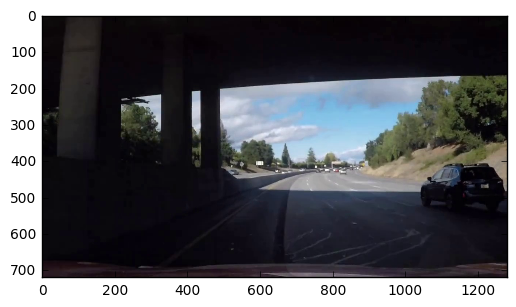

In [2]:
img = cv2.imread('failed/image135.jpg')
plt.imshow(img)

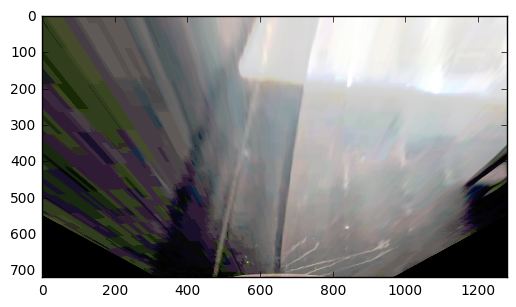

In [3]:
calibrator = cal.Camera_calibrator()
calibrator.initialize()
undist = calibrator.calibrate(img)
warped = w.warp(undist)

eq = np.zeros_like(warped)

eq[:,:,0] = cv2.equalizeHist(warped[:,:,0])
eq[:,:,1] = cv2.equalizeHist(warped[:,:,1])
eq[:,:,2] = cv2.equalizeHist(warped[:,:,2])

plt.imshow(eq)

In [5]:
def equalize(im):
    crcb = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)
    crcb[:,:,0] = cv2.equalizeHist(crcb[:,:,0])
    result = cv2.cvtColor(crcb, cv2.COLOR_YCrCb2RGB)
    return result

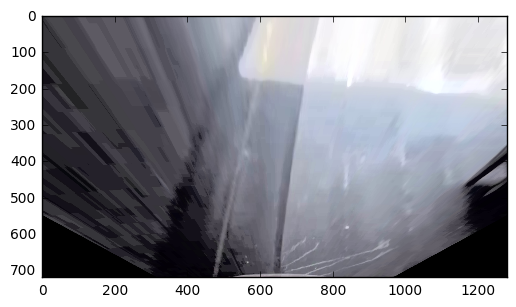

In [6]:
eq = equalize(warped)
plt.imshow(eq)

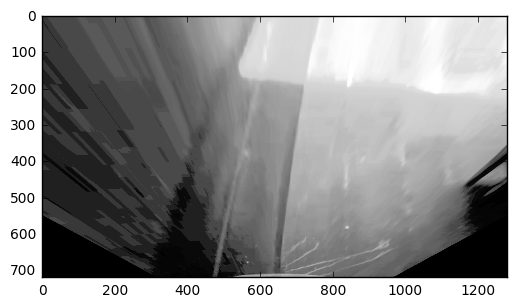

In [7]:
im = cv2.cvtColor(warped, cv2.COLOR_RGB2LAB)
plt.imshow(cv2.equalizeHist(im[:,:,0]), cmap='gray')
plt.imshow(cv2.equalizeHist(im[:,:,0]), cmap='gray')

In [8]:
def edges_chan(chan):
    col = cv2.cvtColor(chan, cv2.COLOR_GRAY2RGB)
    edges = e.Edges(col)
    im = edges.gradient_color_channel(225, 255, channel=2, space=cv2.COLOR_RGB2LUV)
    return im

def hist(im):
    histogram = np.sum(im[im.shape[0]/2:,:], axis=0)
    plt.plot(histogram)    
    
def show_channels(im, space, eq=False, histogram=False, grad=False):
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)    
    conv = cv2.cvtColor(im, space)
    c0 = conv[:,:,0]
    c1 = conv[:,:,1]
    c2 = conv[:,:,2]
    if eq is True:
        c0 = cv2.equalizeHist(c0)
        c1 = cv2.equalizeHist(c1)
        c2 = cv2.equalizeHist(c2)
    
    if grad is True:
        c0 = edges_chan(c0)
        c1 = edges_chan(c1)
        c2 = edges_chan(c2)
        
    if histogram is not True:
        plt.subplot(1, 3, 1)
        plt.title('chan 0')
        c0 = cv2.cvtColor(c0, cv2.COLOR_GRAY2RGB)
        plt.imshow(c0)

        plt.subplot(1,3, 2)
        plt.title('chan 1')
        plt.imshow(c1, cmap='gray')
    

        plt.subplot(1, 3, 3)
        plt.title('chan 2')
        plt.imshow(c2, cmap='gray')
    else:
        plt.subplot(1, 3, 1)
        plt.title('chan 0')
        hist(c0)

        plt.subplot(1,3, 2)
        plt.title('chan 1')
        hist(c1)
    

        plt.subplot(1, 3, 3)
        plt.title('chan 2')
        hist(c2)


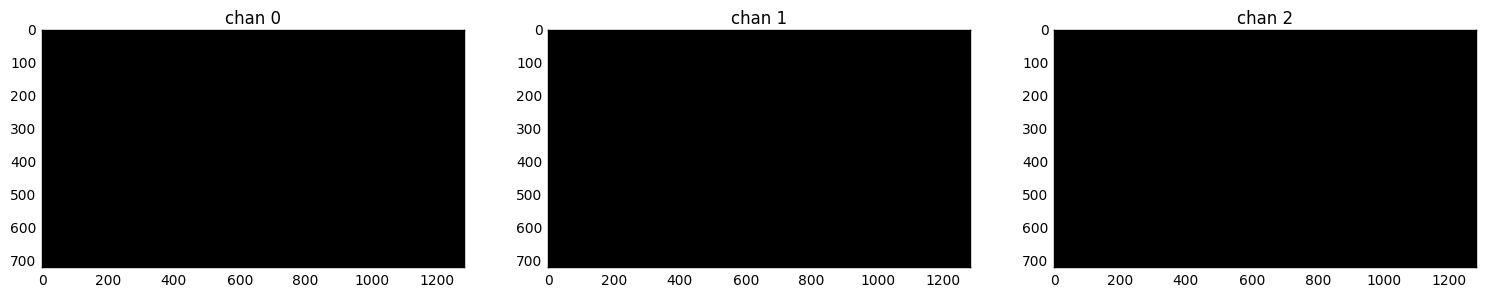

In [9]:
im = warped.copy()
im[:,:,0] = 0
im = im
show_channels(im, cv2.COLOR_RGB2HSV, eq=True, histogram=False, grad=True)

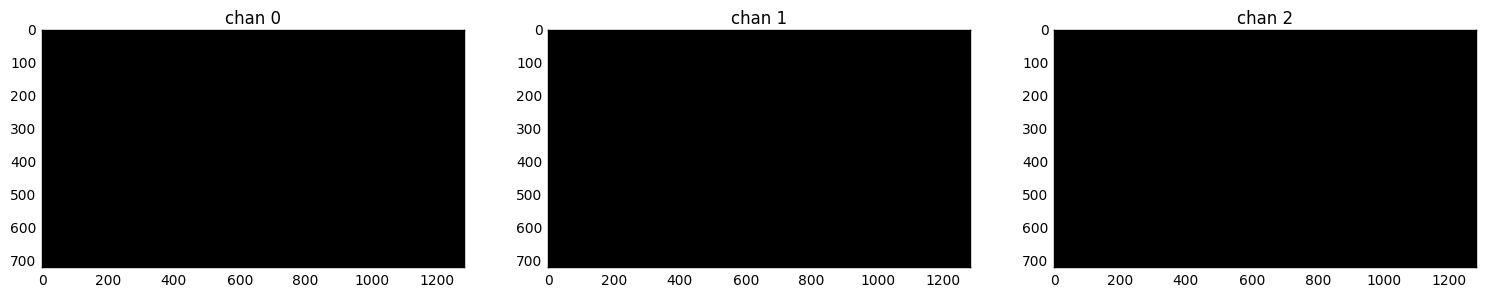

In [10]:
show_channels(warped, cv2.COLOR_RGB2YUV, grad=True)

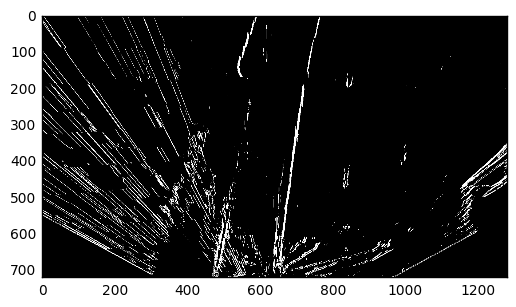

In [11]:
edges = e.Edges(eq)
e_lab = edges.gradient_color_channel(100,255,2,space=cv2.COLOR_RGB2LAB)
e_luv = edges.gradient_color_channel(190,255,0,space=cv2.COLOR_RGB2LUV)
e_hls = edges.gradient_color_channel(230,255,2,space=cv2.COLOR_RGB2HLS)
e_gr = edges.gradient_color_inrange(180, 210, space=cv2.COLOR_RGB2GRAY)
e_x = edges.gradient_x()
e_yl = edges.gradient_color_inrange((20,5,5), (30, 25, 25), cv2.COLOR_RGB2HSV)
#cvInRangeS(imgHSV, cvScalar(20, 100, 100), cvScalar(30, 255, 255), imgThreshed)

plt.imshow(e_x, cmap='gray')

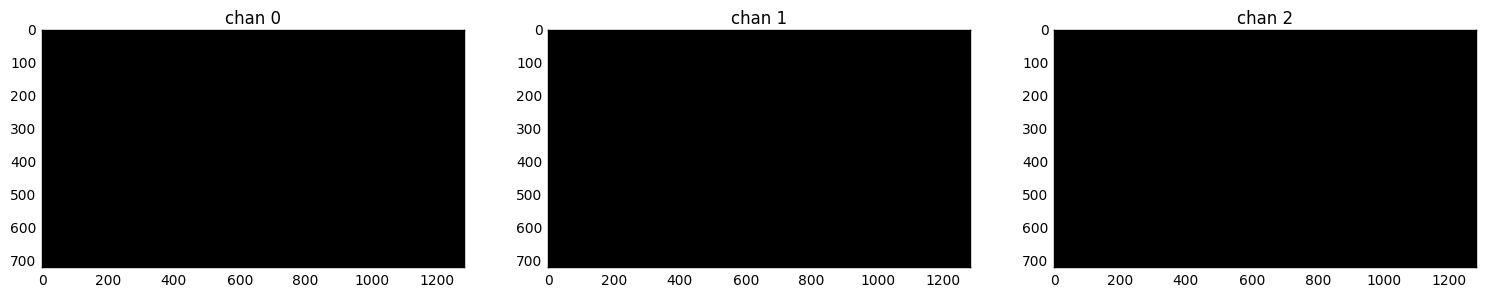

In [12]:
im = warped.copy()
im[:,:,0] = 0
show_channels(im, cv2.COLOR_RGB2YCrCb, eq=True, histogram=False, grad=True)
#plt.imshow(im)

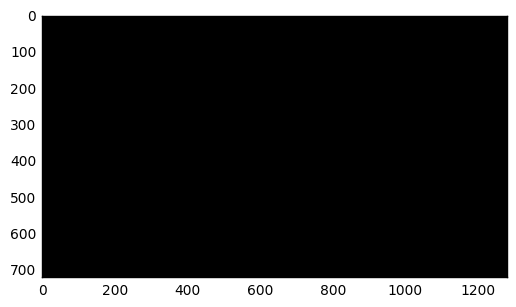

In [13]:
edges = e.Edges(eq)
e_lab = edges.gradient_color_channel(180,255,channel=2,space=cv2.COLOR_RGB2HLS)
e_luv = edges.gradient_color_channel(225,255,channel=0,space=cv2.COLOR_RGB2LUV)
e_hls = edges.gradient_color_channel(155,200,channel=2,space=cv2.COLOR_RGB2Lab)
plt.imshow(e_hls, cmap='gray')

In [14]:
from scipy.misc import imresize, imread

import cv2
import numpy as np

def abs_sobel(img_ch, orient='x', sobel_kernel=3):
    """
    apply the sobel operation on a gray scale image.

    :param img_ch:
    :param orient: 'x' or 'y'
    :param sobel_kernel: an uneven integer
    :return:
    """
    if orient == 'x':
        axis = (1, 0)
    elif orient == 'y':
        axis = (0, 1)

    sobel = cv2.Sobel(img_ch, -1, *axis, ksize=sobel_kernel)
    abs_s = np.absolute(sobel)

    return abs_s

def gradient_magnitude(sobel_x, sobel_y):
    """
    calculate the magnitude of the gradient.
    :param sobel_x:
    :param sobel_y:
    :return:
    """
    abs_grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    return abs_grad_mag.astype(np.uint16)


def gradient_direction(sobel_x, sobel_y):
    """
    calculate the direction of the gradient. NaN values cause by zero division will be replaced
    by the maximum value (np.pi / 2).
    :param sobel_x:
    :param sobel_y:
    :return:
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobel_y / sobel_x))
        abs_grad_dir[np.isnan(abs_grad_dir)] = np.pi / 2

    return abs_grad_dir.astype(np.float32)


def gaussian_blur(img, kernel_size):
    """
    apply a Gaussian Noise kernel
    :param img:
    :param kernel_size:
    :return:
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def extract_yellow(img):
    """
    generate an image mask selecting yellow pixels.
    :param img: image with pixels in range 0-255
    :return: Yellow 255 not yellow 0
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (20, 50, 150), (40, 255, 255))

    return mask


def extract_dark(img):
    """
    generate an image mask selecting dark pixels.
    :param img: image with pixels in range 0-255
    :return: Dark 255 not dark 0
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0, 0, 0.), (255, 153, 128))
    return mask


def extract_highlights(img, p=99.9):
    """
    generate an image mask selecting highlights.
    :param p: percentile for highlight selection. default=99.9
    :param img: image with pixels in range 0-255
    :return: Highlight 255 not highlight 0
    """
    p = int(np.percentile(img, p) - 30)
    mask = cv2.inRange(img, p, 255)
    return mask


def binary_noise_reduction(img, thresh):
    """
    reduce noise of a binary image by applying a filter which counts neighbors with a value
    and only keeping those which are above the threshold.
    :param img: binary image (0 or 1)
    :param thresh: min number of neighbors with value
    :return:
    """
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])
    nb_neighbors = cv2.filter2D(img, ddepth=-1, kernel=k)
    img[nb_neighbors < thresh] = 0
    return img


def generate_lane_mask(img, v_cutoff=0):
    """
    generate a binary mask selecting the lane lines of an street scene image.
    :param img: RGB color image
    :param v_cutoff: vertical cutoff to limit the search area
    :return: binary mask
    """
    window = img[v_cutoff:, :, :]
    yuv = cv2.cvtColor(window, cv2.COLOR_RGB2YUV)
    yuv = 255 - yuv
    hls = cv2.cvtColor(window, cv2.COLOR_RGB2HLS)
    chs = np.stack((yuv[:, :, 1], yuv[:, :, 2], hls[:, :, 2]), axis=2)
    gray = np.mean(chs, 2)

    s_x = abs_sobel(gray, orient='x', sobel_kernel=3)
    s_y = abs_sobel(gray, orient='y', sobel_kernel=3)

    grad_dir = gradient_direction(s_x, s_y)
    grad_mag = gradient_magnitude(s_x, s_y)

    ylw = extract_yellow(window)
    highlights = extract_highlights(window[:, :, 0])

    mask = np.zeros(img.shape[:-1], dtype=np.uint8)

    mask[v_cutoff:, :][((s_x >= 25) & (s_x <= 255) & 
                        (s_y >= 25) & (s_y <= 255)) | 
                       ((grad_mag >= 30) & (grad_mag <= 512) & 
                        (grad_dir >= 0.2) & (grad_dir <= 1.)) | 
                       (ylw == 255) | 
                       (highlights == 255)] = 1

    mask = binary_noise_reduction(mask, 4)

    return mask

def outlier_removal(x, y, q=5):
    """
    remove horizontal outliers based on a given percentile.
    :param x: x coordinates of pixels
    :param y: y coordinates of pixels
    :param q: percentile
    :return: cleaned coordinates (x, y)
    """
    if len(x) == 0 or len(y) == 0:
        return x, y

    x = np.array(x)
    y = np.array(y)

    lower_bound = np.percentile(x, q)
    upper_bound = np.percentile(x, 100 - q)
    selection = (x >= lower_bound) & (x <= upper_bound)


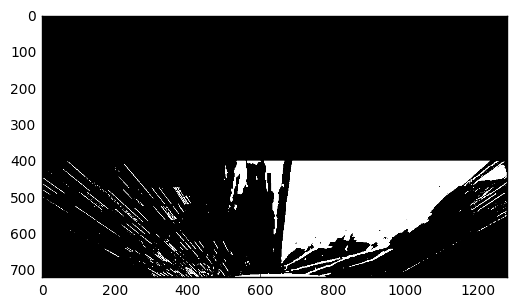

In [18]:
mask = generate_lane_mask(warped,400)
plt.imshow(mask, cmap='gray')